# Variational Quantum Linear Solver in Qiskit

Running on local simulators.

## Introduction

The Variational Quantum Linear Solver (VQLS) aims to take advantage of a variational setup to compute a solution to a linear system, i.e. given a system through a matrix $\mathbf{A}$ we want to find a vector $\mathbf{x}$ such that
$$
    \mathbf{A}\mathbf{x} = \mathbf{b}
$$
The goal is to prepare a quantum state $|x\rangle$, proportional to $\mathbf{x}$, that satisfies the equation.

To prepare this state, we first build an initial parameterized circuit (i.e. an ansatz) $V(\mathbf{\theta})$, where $\mathbf{\theta}\in\mathbb{R}^d$ is the vector of parameters whose elements are generated randomically. Then, we will proceed to modify the $\theta_i$ through multiple runs of an optimization process.

## Setup

Before diving into the VQLS implementation, let's import the necessary packages and modules.

In [1]:
# import
import numpy as np
import scipy as sp
from sympy import symbols
import matplotlib.pyplot as plt

In [2]:
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister, ClassicalRegister
from qiskit.visualization import array_to_latex
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit import Aer, transpile
from qiskit.circuit.library import HGate

from scipy.optimize import minimize

## Step 1: setting up the elements

### Defining the associated matrix $\mathbf{A}$ from the system

We will focus on a small, custom-defined example:
$$
    \mathbf{A} = 0.225\mathbf{Z}_2 + 0.225\mathbf{Z}_3 + 0.55\mathbb{I}
$$
where the subscript indicates the qubit they act upon.

In [3]:
## A matrix
paulis = ['IIZ','IZI','III']
coeffs = [0.225, 0.225, 0.55]

n = 3
N = 2**n

reversed_paulis = [paulis[i][::-1] for i in range(len(paulis))]    
A_matrix = SparsePauliOp(reversed_paulis, coeffs).to_matrix()
array_to_latex(A_matrix, max_size=16)


<IPython.core.display.Latex object>

Since Qiskit works in little endian convention, the string `IIZ` means that a $\mathbf{Z}$ gate is applied onto the first qubit $q_0$, i.e. the order is reversed with the natural and theoretical order:
$$
    IIZ \equiv \mathbf{Z}\otimes \mathbb{I} \otimes \mathbb{I}
$$
However, using `PauliSparseOp.to_matrix()` will compute the tensor product in the reading order, meaning
$$
    IIZ \mapsto \mathbb{I} \otimes \mathbb{I} \otimes \mathbf{Z}
$$
Hence, to get the right associated matrix, we need to reverse the string order before turning the `PauliSparseOp` object into a matrix.

### Building $|b\rangle$: defining the $\mathbf{U}_b$ unitary matrix as a circuit

To implement the algorithm we will also need a circuit (or, equivalently, a unitary matrix) $\mathbf{U}_b$ such that
$$
    \mathbf{U}_b|0\rangle = |b\rangle
$$
where $|b\rangle$ is the normalized version of the given $\mathbf{b}$.

For the purpose of this notebook, we will define $|b\rangle$ as the uniform superposition of all states, which can be obtained by applying an Hadamard gate to every qubit, i.e.
$$
    |b\rangle = \mathbf{H}^{\otimes n} |0\rangle
$$  

In [4]:
## matrix Ub
H_gate = Operator(HGate()).to_matrix()

ph_tensor = np.kron(H_gate,H_gate)
for j in range(n-2):
    ph_tensor = np.kron(ph_tensor,H_gate)

Ub_matrix = ph_tensor
array_to_latex(Ub_matrix, max_size=16)

<IPython.core.display.Latex object>

In [5]:
## Ub circuit
def build_Ub_circuit(n):

    qreg = QuantumRegister(n, name='q')
    qc = QuantumCircuit(qreg)

    for i in range(n):
        qc.h(qreg[i]) 

    return(qc)

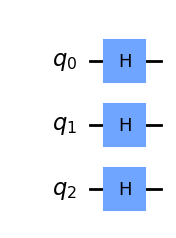

In [6]:
qc = build_Ub_circuit(n)
qc.draw('mpl')

For evaluating our cost function, we will also need a controlled version of the previous circuit.

In [7]:
## matrix controlled-Ub 
def build_controlled_Ub_circuit(n):

    qreg = QuantumRegister(n + 1, name='q')    # var + control
    qc = QuantumCircuit(qreg)

    for i in range(n):
        qc.ch(0,qreg[i+1])

    return(qc)

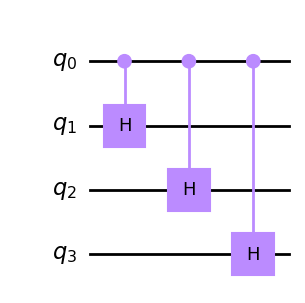

In [8]:
qc = build_controlled_Ub_circuit(n)
qc.draw('mpl')

## Step 2: building the ansatz

Having defined the basic elements of our algorithm, we now move onto building our ansatz, i.e. the parameterized circuit $\mathbf{V}(\theta)$ that we want to optimize.

### Fixed-Hardware Ansatz

The used ansatz is the so-called **Fixed-Hardware Ansatz**, where the 'fixed' refers to the structure (i.e. the gates position) does not vary throughout the optimization. 

This ansatz has the following structure: a layer $'0'$ with rotations around the $Y$ axis on every qubit and then a custom number of layers (defined by the variable `layers`), each one composed by rotations around the $Y$ axis and entanglement operations (the $\mathbf{CZ}s$).

In [9]:
def build_fixed_ansatz(n, layers, parameters):

    qc = QuantumCircuit(n)

    ## initial rotations on layer 0
    for i in range(n):
        qc.ry(parameters[0][i], i)
    
    ## layers (starting from 1)
    if n%2 == 0:
        for layer in range(1,layers):

            ## first CZ
            for i in range(0,n-1,2):       
                qc.cz(i,i+1)
            
            ## Y rotations on all qubits
            for i in range(n):
                qc.ry(parameters[layer][0][i], i)

            ## other CZ
            for i in range(1,n-2,2):       
                qc.cz(i,i+1)

            ## final Y rotations
            for i in range(1,n-1):
                qc.ry(parameters[layer][1][i-1], i)
            qc.barrier()
            
    else:
        for layer in range(1,layers):

            ## first CZ
            for i in range(0,n,2):  
                ph_i = (i+1)%n     
                qc.cz(i,ph_i, label=f'{i}{ph_i}')
            
            ## Y rotations on all qubits
            for i in range(n):
                qc.ry(parameters[layer][0][i], i)

            ## other CZ
            for i in range(1,n): 
                ph_i = (i+1)%n       
                qc.cz(i, ph_i, label=f'{i}{ph_i}')

            ## final Y rotations
            for i in range(n):
                qc.ry(parameters[layer][1][i], i)
       
    return(qc)

We can change the number of layers based on our necessities, but for now let's build an ansatz for our problem with one custom layers and one full of rotations.

For now, we don't need to take into much consideration the parameters $\theta_i$, so we'll use the Qiskit class `Parameters` to define the needed placeholders. We will later substitute them with a random initialization to run our optimizer.

Finally, since we need this parameters to be organized in a list of lists based on the layer and the level they need to be put in, we will re-format the list through the function `separate_parameters`. This function will be called directly in the cost evaluation, but we leave an example of how it works in the following cell:

In [10]:
# auxiliary function to correctly format the array of parameters
def separate_parameters(parameters, layers):

    global n

    ph_params = []

    if n%2 == 0:

        stride0 = n
        stride1 = n - 2
        start = 0

        for layer in range(layers):
            if layer == 0:
                end = start + stride0
                ph_params.append(parameters[start:end])
                start = end
            else:
                ph_list = []
                level = 0
                while level < 2:
                    if level == 0:
                        end = start + stride0
                        ph_list.append(parameters[start:end])
                        level += 1
                        start = end
                    else:
                        end = start + stride1
                        ph_list.append(parameters[start:end])
                        level += 1
                        start = end
                ph_params.append(ph_list)
    else:

        stride = n
        start = 0

        for layer in range(layers):
            if layer == 0:
                end = start + stride
                ph_params.append(parameters[start:end])
                start = end
            else:
                ph_list = []
                level = 0
                while level < 2:
                    if level == 0:
                        end = start + stride
                        ph_list.append(parameters[start:end])
                        level += 1
                        start = end
                    else:
                        end = start + stride
                        ph_list.append(parameters[start:end])
                        level += 1
                        start = end
                ph_params.append(ph_list)

    return(ph_params)

Let's see an example of this formatting:

In [11]:
## hyperparameters
layers = 1 + 1

## number of parameters
num_thetas = n
if n%2 == 0: 
    num_thetas += (layers - 1)*(2*n - 2)
else:
    num_thetas += (layers - 1)*(2*n)
print(f'Total number of parameters: {num_thetas}\n')

## parameters
thetas = [Parameter(f'theta{i}') for i in range(num_thetas)]
separate_thetas = separate_parameters(thetas, layers)

print(f'List of parameters before formatting: \n{thetas}\n')
print(f'List of parameters after formatting: \n{separate_thetas}')

Total number of parameters: 9

List of parameters before formatting: 
[Parameter(theta0), Parameter(theta1), Parameter(theta2), Parameter(theta3), Parameter(theta4), Parameter(theta5), Parameter(theta6), Parameter(theta7), Parameter(theta8)]

List of parameters after formatting: 
[[Parameter(theta0), Parameter(theta1), Parameter(theta2)], [[Parameter(theta3), Parameter(theta4), Parameter(theta5)], [Parameter(theta6), Parameter(theta7), Parameter(theta8)]]]


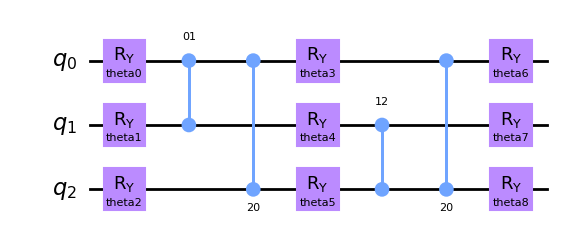

In [12]:
## fixed_ansatz building
fixed_ansatz = QuantumCircuit(n)
fixed_ansatz.compose(build_fixed_ansatz(n=n, layers=layers,
                                        parameters=separate_thetas), inplace=True)
fixed_ansatz.draw('mpl')

### Controlled-Fixed-Ansatz

Let's then build the controlled version of our fixed-ansatz, which we'll use in the next step to evaluate our cost function.

In [13]:
def build_controlled_fixed_ansatz(n, layers, n_auxs, parameters):

    n_qubits = n + n_auxs
    qreg = QuantumRegister(n_qubits, name='q')
    qc = QuantumCircuit(qreg)

    ## initial C-rotations on layer 0
    for i in range(n):
        qc.cry(parameters[0][i], qreg[0], qreg[i+1])
    
    ## layers (starting from 1)
    if n%2 == 0:
        for layer in range(1,layers):

            ## first CCZ
            for i in range(0,n-1,2):   
                qc.ccz(0,qreg[i+1],qreg[i+2],label=f'0{i+1}{i+2}')    
            
            ## CY rotations on all qubits
            for i in range(n):
                qc.cry(parameters[layer][0][i], qreg[0], qreg[i+1])

            ## other CCZ
            for i in range(1,n-2,2):       
                qc.ccz(0,qreg[i+1],qreg[i+2],label=f'0{i+1}{i+2}')

            ## final Y rotations
            for i in range(1,n-1):
                qc.cry(parameters[layer][1][i-1], qreg[0], qreg[i+1])
    else:
        for layer in range(1,layers):

            ## first CCZ
            for i in range(1,n):  
                ph_i = (i+1)%(n)
                if ph_i == 0:
                    qc.ccz(0,qreg[i+1],qreg[ph_i+1],label=f'0{i+1}{ph_i+1}') #031
                else:
                    qc.ccz(0,qreg[i],qreg[ph_i],label=f'0{i}{ph_i}')        #012
            
            ## CY rotations on all qubits
            for i in range(n):
                qc.cry(parameters[layer][0][i], qreg[0], qreg[i+1])

            ## other CCZ
            for i in range(2,n+1):   
                ph_i = (i+1)%(n+1)
                if ph_i == 0:
                    qc.ccz(0,qreg[i],qreg[ph_i+1],label=f'0{i}{ph_i+1}') #031
                else:
                    qc.ccz(0,qreg[i],qreg[ph_i],label=f'0{i}{ph_i}') #023
   

            ## final CY rotations
            for i in range(n):
                qc.cry(parameters[layer][1][i], qreg[0], qreg[i+1])
                
    return(qc)

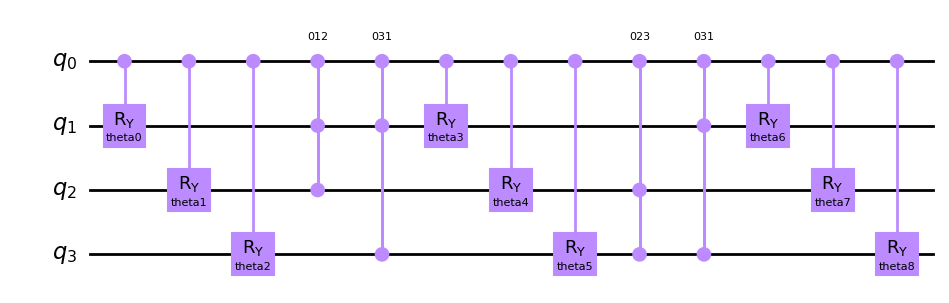

In [14]:
qc = build_controlled_fixed_ansatz(n, layers, 1, separate_thetas)
qc.draw('mpl')

## Step 3: evalutaing the cost Function

### Theory

Remark: we are assuming $\mathbf{A}$ can be rewritten as/is given as a linear combination of unitary matrices:
$$
    \mathbf{A} = \sum_{l=1}^L c_l \mathbf{A}_l
$$

A first cost function can be defined as the overlap between the unnormalized projector $|\psi\rangle\langle\psi|$ and the subspace orthogonal to $|b\rangle$, i.e.
$$
    \hat{C}_G = Trace\bigg( |\psi\rangle\langle\psi|(\mathbb{I} - |b\rangle\langle b|) \bigg) = \langle x|\mathcal{H}_G|x\rangle 
$$ 
which can be viewed as the expectation value of the following effective Hamiltonian:
$$
    \mathcal{H}_G = \mathbf{A}^\dagger (\mathbb{I}  - |b\rangle\langle b|)\mathbf{A}
$$
It is important to notice that $\hat{C}_G$ is small either if $|\psi\rangle \propto |b\rangle$ or if the norm of $|\psi\rangle$ is small: the latter, though, does not represent a solution to our problem, hence we need to normalize the state in order to work with a cost function that will be minimized only when a solution is found. The modified cost function can then be defined as
$$
    C_G =\frac{\hat{C}_G}{\langle\psi|\psi\rangle} = 1 - |\langle b|\Psi\rangle|^2
$$
where $\Psi = \frac{|\psi\rangle}{\sqrt{\langle\psi|\psi\rangle}}$.

Though very intuitive, this cost function is **global** and as such it is more likely to exhibit barren plateaus issues, slowing the optimization routine. In order to avoid this, a second function cost can be defined as the local version of the one just presented:
$$
    \hat{C}_L = \langle x|\mathcal{H}_L|x\rangle  \qquad C_L = \frac{\hat{C}_L}{\langle\psi|\psi\rangle}
$$
where $\mathcal{H}_L$ is the the effective Hamiltonian
$$
    \mathcal{H}_L = \mathbf{A}^\dagger \mathbf{U}_b \underbrace{\left( \mathbb{I}  - \frac{1}{n}\sum_{k=1}^{n}|0_k\rangle\langle 0_k|\otimes \mathbb{I}_{\overline{k}}\right)}_{:= \mathbf{B}} \mathbf{U}_b^\dagger \mathbf{A}
$$
with $|0_k\rangle$ being the zero state on qubit $k$ and $\mathbb{I}_{\overline{k}}$ the identity on all qubits except qubit $k$. The idea is to count how many qubits are different between $|\psi\rangle =: \mathbf{A}|x(\theta)\rangle = (\mathbf(AV)(\theta))|0\rangle$, i.e. our estimate from the circuit, and $|b\rangle$.

The **goal** of the algorithm can then be reduced to find an optimal set of parameters $\theta_{opt} = \{\theta_{opt,i}\}_i$ such that 
$$
    |\psi\rangle = \mathbf{AV}(\theta_{opt})|0\rangle \propto |b\rangle
$$
Since we are looking for *a* solution to our system, we can just concentrate in finding a state $|x\rangle$ that will output a state proportional to $|b\rangle$.

In order to evaluate the global cost function we need to compute two quantities, namely $|\langle b|\psi\rangle|^2$ and $\langle\psi|\psi\rangle$. 

To evaluate $\langle\psi|\psi\rangle$, let's consider
$$
    \langle\psi|\psi\rangle = \sum_{ij} c_i c_j^* \beta_{ij}
$$
with
$$
    \beta_{ij} = \langle0| \mathbf{V}^\dagger\mathbf{A}_{j}^{\dagger}\mathbf{A}_{i}\mathbf{V}|0\rangle
$$
Our goal is then reduced to estimate the $L^2$ paramters $\beta_{ij}$ and we can achieve this through a subroutine called **Hadamard Test**.

The Hadamard Test is a quantum routine that allows to calculate the real part of the expectation value of a unitary operation by running a specific circuit, namely
<center>

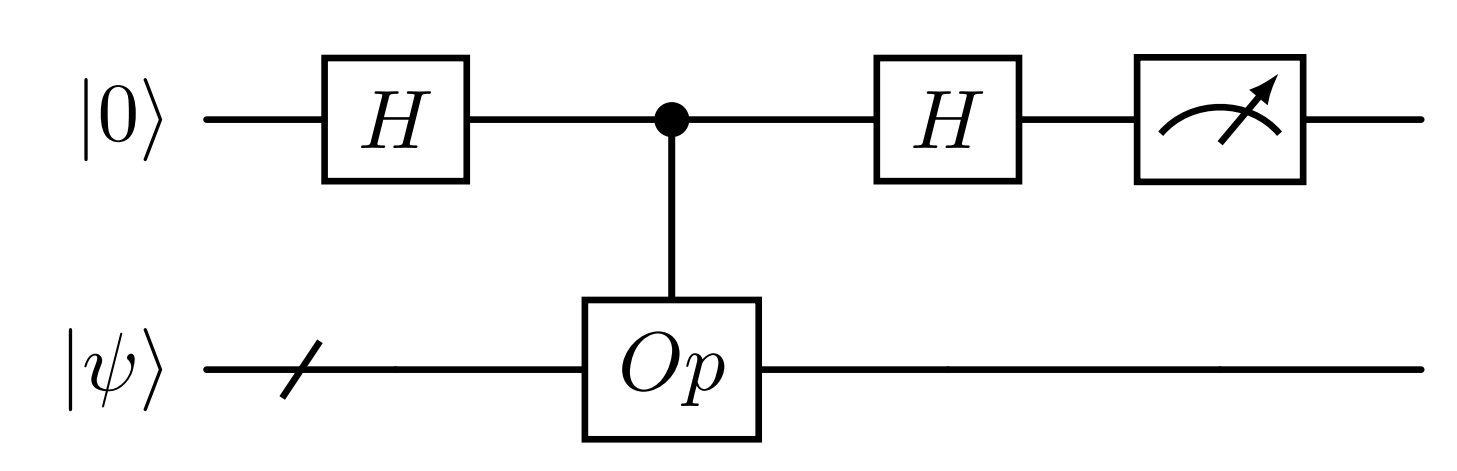

</center>

This way, the expectation value of the circuit is exactly $\Re(\langle\psi|\mathbf{Op}|\psi\rangle)$. It is also possible to modify this circuit, by adding a phase gate on the first quantum register, to get the imaginary part of the same expectation value. In our case, everything is real so we won't need to apply this gate, even though it is implemented in the code through the string variable `case`.

For the term $|\langle b|\psi\rangle|^2$, we can move analougously:
$$
    |\langle b|\psi\rangle|^2 = |\langle 0|\mathbf{U}_b^\dagger\mathbf{A}\mathbf{V}|0\rangle|^2 = \sum_{ij} c_i c_j^* \gamma_{ij}
$$
with
$$
    \gamma_{ij} = \langle0|\mathbf{U}_b^\dagger\mathbf{A}_i\mathbf{V}|0\rangle 
                   \langle0|\mathbf{V}^\dagger\mathbf{A}_{j}^\dagger\mathbf{U}_b|0\rangle
$$
We can achieve this either through a subroutine called **Hadamard-Overlap Test** or a standard Hadamard Test, turning every operation into a controlled version of itself. We will implement the latter circuit.

Finally, to evaluate the local cost function we'll need to compute some other terms, but let's first try and expand our cost function:

Given that
$$
    \begin{equation}
    C_L = \frac{\langle x|\mathcal{H}_L|x\rangle}{\langle\psi|\psi\rangle}
    \end{equation}
$$
and that
$$
    \mathcal{H}_L = \mathbf{A}^\dagger \mathbf{U}_b\left( \mathbb{I}  - \frac{1}{n}\sum_{k=1}^{n}|0_k\rangle\langle 0_k|\otimes \mathbb{I}_{\overline{k}}\right) \mathbf{U}_b^\dagger \mathbf{A}
$$
we can rewrite the numerator in $(1)$ as
$$
    \begin{align*}
        \langle x|\mathcal{H}_L|x\rangle &= \left\langle x \Bigg\vert \mathbf{A}^\dagger \mathbf{U}_b\left( \mathbb{I}  - \frac{1}{n}\sum_{k=1}^{n} \underbrace{|0_k\rangle\langle 0_k|\otimes \mathbb{I}_{\overline{k}}}_{:= \mathbf{P}_k}\right)\mathbf{U}_b^\dagger \mathbf{A} \Bigg\vert x\right\rangle\\
        \\
        &= \underbrace{\langle x|\mathbf{A}^\dagger}_{=\langle\psi|} \mathbf{U}_b \mathbf{U}_b^\dagger \underbrace{\mathbf{A}|x\rangle}_{=|\psi\rangle} - \frac{1}{n} \sum_{k=1}^{n} \langle x|\mathbf{A}^\dagger\mathbf{U}_b\mathbf{P}_k\mathbf{U}_b^\dagger\mathbf{A}|x\rangle = \\

        \\
        &= \langle \psi | \psi \rangle - \frac{1}{n} \sum_{k=1}^{n} \langle \psi |\mathbf{U}_b\mathbf{P}_k\mathbf{U}_b^\dagger|\psi\rangle
    \end{align*}
$$
Then
$$
    C_L = 1 - \frac{1}{n\langle \psi | \psi \rangle}\sum_{k=1}^{n} \langle \psi |\mathbf{U}_b\mathbf{P}_k\mathbf{U}_b^\dagger|\psi\rangle
$$
We already know how to estimate $\langle \psi | \psi \rangle$, therefore we only need to understand how to retrieve the addends. In order to do so, let's observe that we can rewrite $|0_k\rangle\langle 0_k|$ as $\frac{\mathbb{I}_k + \mathbf{Z}_k}{2}$, meaning that
$$
    \begin{align*}
        \langle \psi |\mathbf{U}_b\mathbf{P}_k\mathbf{U}_b^\dagger|\psi\rangle &= \langle \psi |\mathbf{U}_b\left(|0_k\rangle\langle 0_k|\otimes \mathbb{I}_{\overline{j}}\right)\mathbf{U}_b^\dagger|\psi\rangle =\\

        &= \langle \psi |\mathbf{U}_b\left(\frac{\mathbb{I}_k + \mathbf{Z}_k}{2}\otimes \mathbb{I}_{\overline{j}}\right)\mathbf{U}_b^\dagger|\psi\rangle =\\

        &= \frac{1}{2}\left(\langle \psi |\mathbf{U}_b\mathbb{I}\mathbf{U}_b^\dagger|\psi\rangle + \langle \psi |\mathbf{U}_b(\mathbf{Z}_k\otimes \mathbb{I}_{\overline{j}})\mathbf{U}_b^\dagger|\psi\rangle \right) =\\

        &= \frac{1}{2}\left(\langle \psi |\psi\rangle + \langle \psi |\mathbf{U}_b(\mathbf{Z}_k\otimes \mathbb{I}_{\overline{j}})\mathbf{U}_b^\dagger|\psi\rangle \right)
    
    \end{align*}
$$
Hence
$$
    \begin{align*}
            C_L &= 1 - \frac{1}{2n\langle \psi | \psi \rangle}\left[\:\sum_{k=1}^{n} \langle \psi |\psi\rangle + \sum_{k=1}^{n}\langle \psi |\mathbf{U}_b(\mathbf{Z}_k\otimes \mathbb{I}_{\overline{k}})\mathbf{U}_b^\dagger|\psi\rangle\:\right] = \\
            \\
            &= \frac{1}{2} - \frac{1}{2n\langle \psi | \psi \rangle}\sum_{k=1}^{n}\langle \psi |\mathbf{U}_b(\mathbf{Z}_k\otimes \mathbb{I}_{\overline{k}})\mathbf{U}_b^\dagger|\psi\rangle = \\
            \\
            &= \frac{1}{2} - \frac{1}{2n\langle \psi | \psi \rangle}\sum_{k=1}^{n} \langle 0 |\mathbf{V}^\dagger \mathbf{A}^\dagger\mathbf{U}_b(\mathbf{Z}_k\otimes \mathbb{I}_{\overline{k}})\mathbf{U}_b^\dagger\mathbf{A}\mathbf{V}|0\rangle =\\
            \\
            &= \frac{1}{2} - \frac{1}{2n\langle \psi | \psi \rangle}\sum_{k=1}^{n} \sum_{ij} c_i c^*_j \langle 0 |\mathbf{V}^\dagger \mathbf{A}^\dagger_{j}\mathbf{U}_b(\mathbf{Z}_k\otimes \mathbb{I}_{\overline{k}})\mathbf{U}_b^\dagger\mathbf{A}_{i}\mathbf{V}|0\rangle
        \end{align*}
$$
We can then apply an Hadamard Test to estimate the terms $\tilde{\delta}^{(k)}_{ij}$, such that
$$
    \begin{align*}
        \tilde{\delta}^{(k)}_{ij}=
        \langle 0 |\mathbf{V}^\dagger \mathbf{A}^\dagger_{j}\mathbf{U}_b(\mathbf{Z}_k\otimes \mathbb{I}_{\overline{k}})\mathbf{U}_b^\dagger\mathbf{A}_{i}\mathbf{V}|0\rangle 
    \end{align*}
$$
for every $k=1,\ldots,n$.

This concludes our evalutation of the cost function.

### Hadamard Test for $\beta_{ij}$

In [15]:
## hadamard test to estimate <psi|psi> through beta_ij
def hadamard_test_fixed_beta(gates_ai, gates_aj, n, aux_index, parameters, layers, case):

    qc = QuantumCircuit(n+1, 1)
    qc_qubits = [i for i in range(1, n+1)]

    ## first hadamard
    qc.h(aux_index)

    ## phase gate
    if case == 'imaginary':
        S_dagger = Operator([[1,0],[0,-1j]])
        qc.unitary(S_dagger, aux_index, label='S^*')

    ## barrier
    qc.barrier()

    ## ansatz (V)
    qc.compose(build_fixed_ansatz(n=n, layers=layers, 
                                  parameters=parameters), 
               qubits=qc_qubits,inplace=True)

    ## barrier
    qc.barrier()

    ## Controlled-A_i
    index_count = 1
    CAi = QuantumCircuit(n+1, 1)
    for pauli in gates_ai:
        if pauli == 'Z':
            CAi.cz(aux_index, index_count)
        elif pauli == 'X':
            CAi.cx(aux_index, index_count)
        index_count += 1
    qc.compose(CAi, inplace=True)
    
    ## barrier
    qc.barrier()

    ## Controlled-A_j^dagger
    index_count = 1
    CAj = QuantumCircuit(n+1, 1)
    for pauli in gates_aj:
        if pauli == 'Z':
            CAj.cz(aux_index, index_count)
        elif pauli == 'X':
            CAj.cx(aux_index, index_count)
        index_count += 1
    qc.compose(CAj.inverse(), inplace=True)     # since A_j is unitary, its inverse is the conj. transpose
    
    ## barrier
    qc.barrier()

    ## final hadamard
    qc.h(aux_index)

    ## measure aux
    qc.measure(aux_index, 0)

    return(qc)

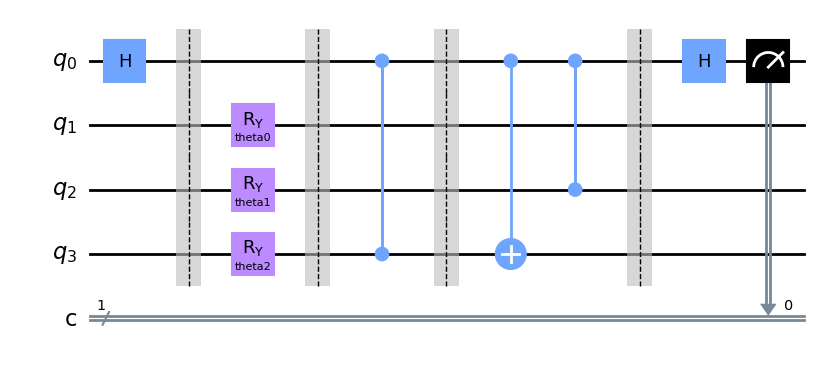

In [16]:
# example
qc = hadamard_test_fixed_beta('IIZ','IZX', n, 0, separate_thetas, 1, 'real')
qc.draw('mpl')

### Hadamard Test for $\gamma_{ij}$

In [17]:
def aux_hadamard_test_fixed_i(n, aux_index, CV, CA, CU, case):

    had_i = QuantumCircuit(n+1, 1)

    ## first hadamard
    had_i.h(aux_index)

    ## phase gate
    if case == 'imaginary':
        S_dagger = Operator([[1,0],[0,-1j]])
        had_i.unitary(S_dagger, aux_index, label='S^*')
    
    ## building
    had_i.compose(CV, inplace=True)
    had_i.compose(CA, inplace=True)
    had_i.compose(CU.inverse(), inplace=True)

    ## final hadamard
    had_i.h(aux_index)

    ## measure aux
    had_i.measure(aux_index, 0)

    return(had_i)

In [18]:
def aux_hadamard_test_fixed_j(n, aux_index, CV, CA, CU, case):

    had_j = QuantumCircuit(n+1, 1)

    ## first hadamard
    had_j.h(aux_index)

    ## phase gate
    if case == 'imaginary':
        S_dagger = Operator([[1,0],[0,-1j]])
        had_j.unitary(S_dagger, aux_index, label='S^*')
    
    ## building
    had_j.compose(CU, inplace=True)
    had_j.compose(CA.inverse(), inplace=True)
    had_j.compose(CV.inverse(), inplace=True)

    ## final hadamard
    had_j.h(aux_index)

    ## measure aux
    had_j.measure(aux_index, 0)

    return(had_j)

In [19]:
## hadamard test to estimate <b|psi> through gamma_ij
def hadamard_test_fixed_gamma(gates_ai, gates_aj, n, aux_index, parameters, layers, case):

    ## Controlled-V
    CV = build_controlled_fixed_ansatz(n=n, layers=layers,
                                      n_auxs=1, parameters=parameters)
    
    ## Controlled-Ub
    CUb = build_controlled_Ub_circuit(n)

    ## Controlled-A_i
    index_count = 1
    CAi = QuantumCircuit(n+1, 1)
    for pauli in gates_ai:
        if pauli == 'Z':
            CAi.cz(aux_index, index_count)
        elif pauli == 'X':
            CAi.cx(aux_index, index_count)
        index_count += 1
    
    ## Controlled-A_j^dagger
    index_count = 1
    CAj = QuantumCircuit(n+1, 1)
    for pauli in gates_aj:
        if pauli == 'Z':
            CAj.cz(aux_index, index_count)
        elif pauli == 'X':
            CAj.cx(aux_index, index_count)
        index_count += 1

    ## First hadamard test
    had_i = aux_hadamard_test_fixed_i(n, aux_index, CV, CAi, CUb, case)

    ## Second Hadamard test
    had_j = aux_hadamard_test_fixed_j(n, aux_index, CV, CAj, CUb, case)
    
    return(had_i, had_j)

In [20]:
had_i, had_j = hadamard_test_fixed_gamma('ZIX', 'XIZ', n, 0, separate_thetas, layers, 'Real')

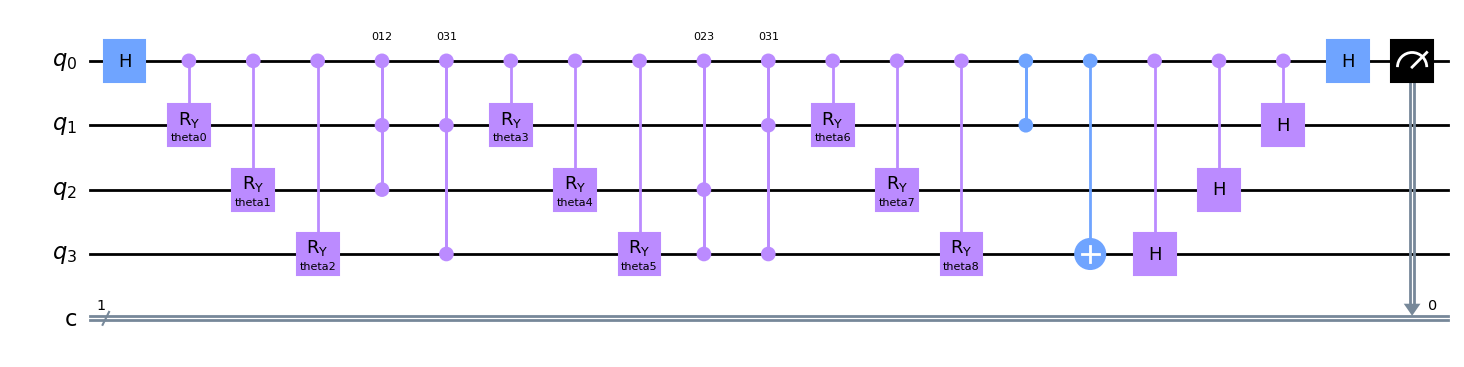

In [21]:
had_i.draw('mpl')

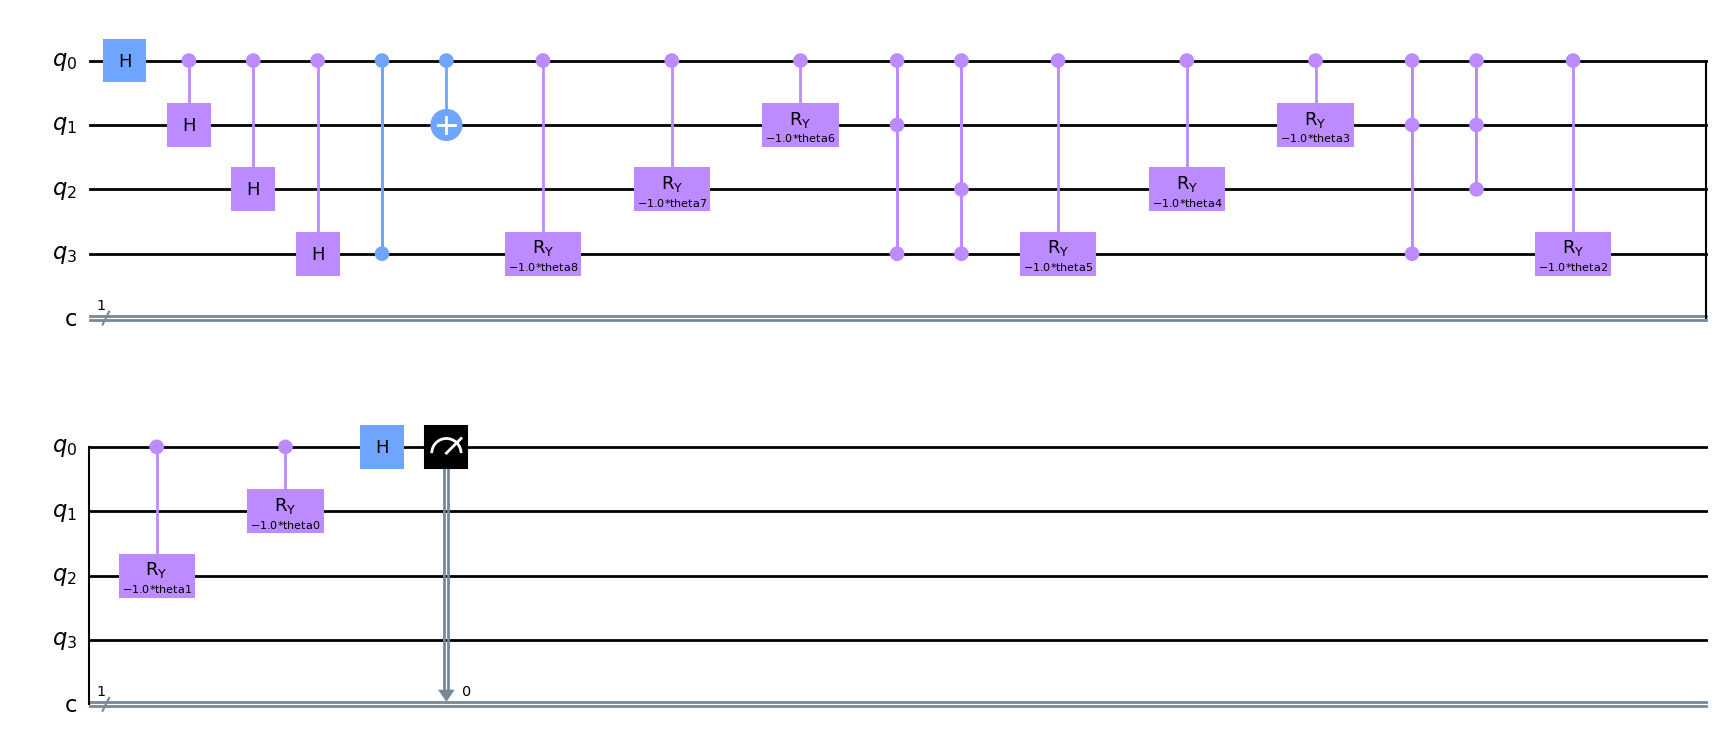

In [22]:
had_j.draw('mpl')

### Hadamard Test for $\tilde{\delta}^{(k)}_{ij}$

In [23]:
## hadamard test to estimate delta^(k)_ij
def hadamard_test_fixed_delta_k(k, gates_ai, gates_aj, n, aux_index, parameters, layers, case):

    qc = QuantumCircuit(n+1, 1)
    qc_qubits = [i for i in range(1, n+1)]

    ## first hadamard
    qc.h(aux_index)

    ## phase gate
    if case == 'imaginary':
        S_dagger = Operator([[1,0],[0,-1j]])
        qc.unitary(S_dagger, aux_index, label='S^*')

    ## ansatz (V)
    qc.compose(build_fixed_ansatz(n=n, layers=layers, 
                                  parameters=parameters), 
               qubits=qc_qubits,inplace=True)

    ## barrier
    qc.barrier()

    ## Controlled-A_i
    index_count = 1
    CAi = QuantumCircuit(n+1, 1)
    for pauli in gates_ai:
        if pauli == 'Z':
            CAi.cz(aux_index, index_count)
        elif pauli == 'X':
            CAi.cx(aux_index, index_count)
        index_count += 1
    qc.compose(CAi, inplace=True)

    ## barrier
    qc.barrier()

    ## Ub^dagger circuit
    qc.compose(build_Ub_circuit(n).inverse(), qubits=qc_qubits, inplace=True)

    ## barrier
    qc.barrier()
    
    ## Reduced controlled-B = CZ on qubit k
    qc.cz(aux_index, k+1)

    ## barrier
    qc.barrier()

    ## Ub circuit
    qc.compose(build_Ub_circuit(n), qubits=qc_qubits, inplace=True)

    ## barrier
    qc.barrier()

    ## Controlled-A_j^dagger
    index_count = 1
    CAj = QuantumCircuit(n+1, 1)
    for pauli in gates_aj:
        if pauli == 'Z':
            CAj.cz(aux_index, index_count)
        elif pauli == 'X':
            CAj.cx(aux_index, index_count)
        index_count += 1
    qc.compose(CAj.inverse(), inplace=True)
    
    ## barrier
    qc.barrier()

    ## final hadamard
    qc.h(aux_index)

    ## measure aux
    qc.measure(aux_index, 0)

    return(qc)


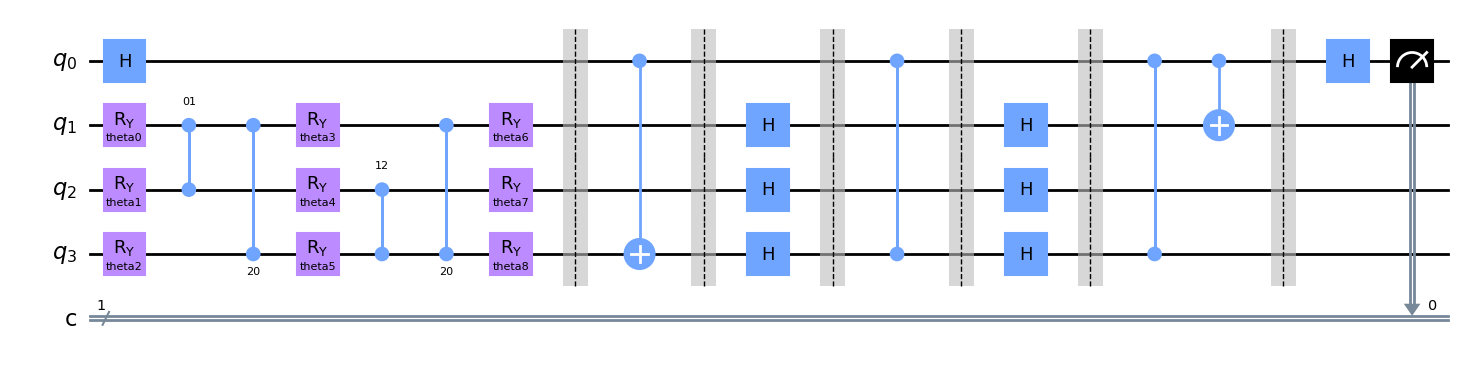

In [24]:
delta_k = hadamard_test_fixed_delta_k(2, 'IIX', 'XIZ', n, 0, separate_thetas, layers, 'Real')
delta_k.draw('mpl')

### Cost Evaluation

We can now try to evaluate our cost function, without any optimization.

In order to do so, we define a few auxiliary functions that will compute the aforementioned terms through the Hadamard tests and will output the parts we need to evaluate our cost function.

The circuits for the Hadamard Tests, for now, will all be run on simulator for a certain number of times (=`num_shots`) and, from this results, we will then calculate the quasi-distribution of measuring $1$. This quasi-distribution is necessary as we will estimate our $\beta_{ij}$, $\gamma_{ij}$, and $\tilde{\delta}^{(k)}_{ij}$ using the fact that
$$
    \mathbb{P}(1) = \frac{1-\Re(\beta_{ij})}{2}
$$
i.e.
$$
    \Re(\beta_{ij}) = 1 - 2\mathbb{P}(1)
$$
and similarly for $\gamma_{ij},\tilde{\delta}^{(k)}_{ij}$.

#### Global cost evaluation

When working with a small number of qubits, like in this example, using a global cost function may not hinder our search, so let's implement it and give it a try!

In [25]:
def get_psi_dot_psi(n, layers, paulis_list, paulis_coeffs, parameters):

    dotprod = 0
    num_paulis = len(paulis_list)

    for i in range(num_paulis):
        for j in range(num_paulis):

            qreg = QuantumRegister(n+1, name='q')
            creg = ClassicalRegister(1, name='c')
            qc = QuantumCircuit(qreg, creg)

            num_shots = 100000
            backend = Aer.get_backend('aer_simulator', num_shots = num_shots)

            cc = paulis_coeffs[i]*paulis_coeffs[j]
            # technically, c_j should be complex conjugated, 
            # but our coeffs are always real

            qc.compose(hadamard_test_fixed_beta(gates_ai=paulis_list[i], gates_aj=paulis_list[j],
                                                n=n, aux_index=0, parameters=parameters,
                                                layers=layers, case='Real'), 
                       inplace=True)   
            
            transpiled_qc = transpile(qc, backend)
            result = backend.run(transpiled_qc).result()
            
            outputstate = result.get_counts()
            #print(f'Output state:{outputstate}')

            prob1 = 0
            if '1' in outputstate.keys():
                prob1 = float(outputstate['1'])/num_shots
            beta_ij = 1-2*prob1
            
            dotprod += cc*beta_ij

    return(dotprod)

In [26]:
def get_b_dot_psi_global(n, layers, paulis, coeffs, parameters):

    dotprod = 0

    for i in range(len(paulis)):
        for j in range(len(paulis)):

            cc = coeffs[i]*coeffs[j]

            had_i, had_j = hadamard_test_fixed_gamma(paulis[i], paulis[j], n,
                                                     0, parameters, layers, 'Real')
            
            num_shots = 100000
            backend = Aer.get_backend('aer_simulator', num_shots=num_shots)

            t_had_i = transpile(had_i, backend)
            t_had_j = transpile(had_j, backend)

            result_i = backend.run(t_had_i).result()
            result_j = backend.run(t_had_j).result()

            outputstate_i = result_i.get_counts()
            outputstate_j = result_j.get_counts()

            prob1_i = 0
            if '1' in outputstate_i.keys():
                prob1_i = float(outputstate_i['1'])/num_shots
            ph_i = 1-2*prob1_i

            prob1_j = 0
            if '1' in outputstate_j.keys():
                prob1_j = float(outputstate_j['1'])/num_shots
            ph_j = 1-2*prob1_j

            gamma_ij = ph_i*ph_j

            dotprod += cc*gamma_ij

    return(dotprod)

In [27]:
def global_cost_function(parameters):
    
    ## variables
    global n, layers, paulis, coeffs, it, global_cost_plot

    parameters = separate_parameters(parameters,layers)    

    ## psi_psi
    psi_psi = get_psi_dot_psi(n=n, layers=layers, paulis_list=paulis,
                                        paulis_coeffs=coeffs,
                                        parameters=parameters)

    ## |b_psi|^2
    b_psi = get_b_dot_psi_global(n, layers, paulis, coeffs, parameters)

    ## estimate
    num = np.real(b_psi)
    den = np.real(psi_psi)
    estimate = 1 - float(num/den)

    #print(f'psipsi = {psi_psi}, |bpsi|^2 = {b_psi}')
    print(f'Iteration: {it} \t Cost evaluation: {estimate}')
    global_cost_plot.append(estimate)

    it += 1

    return(estimate)

To evaluate our cost function, we need to define a starting point from which we will later optimize our parameters: having calculated the total number of parameters in our ansatz, we then call the function `randint` from Numpy to generate random integer values for each one of them and store this values in a generic list.

Other common initialization can be implemented for comparison, just comment/decomment lines in the following cell.

In [28]:
## starting point

#initial_theta = [np.random.normal(0,1) for _ in range(0, num_thetas)]              ## normal initialization
initial_theta = [np.random.rand() for _ in range(0, num_thetas)]                    ## random initialization

#initial_theta = [0 for _ in range(0, num_thetas)]                                  ## all zeros initialization
#initial_theta = [1/N for _ in range(0, num_thetas)]                                ## uniform initialization

print(f'Starting point:{initial_theta}')

Starting point:[0.9364074341154939, 0.9131020711183478, 0.08296006318230842, 0.8470869568663965, 0.5159052029041769, 0.17801566765683308, 0.9385510835514878, 0.1295043776056809, 0.7465684949732401]


We also define an auxiliary list to save cost evaluations for every iteration so as to plot them after the optimization.

Let's try a first evaluation:

In [29]:
it = 0
global_cost_plot = []

global_cost_function(initial_theta)

Iteration: 0 	 Cost evaluation: 0.006975804125570861


0.006975804125570861

### Local cost evaluation

Similarly, we can implement our local cost function:

In [30]:
def get_b_dot_psi_local(k, n, layers, paulis_list, paulis_coeffs, parameters):

    dotprod = 0
    num_paulis = len(paulis_list)

    for i in range(num_paulis):
        for j in range(num_paulis):

            qreg = QuantumRegister(n+1, name='q')
            creg = ClassicalRegister(1, name='c')
            qc = QuantumCircuit(qreg, creg)

            num_shots = 100000
            backend = Aer.get_backend('aer_simulator', num_shots = num_shots)

            cc = paulis_coeffs[i]*paulis_coeffs[j]
            # technically, c_j should be complex conjugated, 
            # but our coeffs are always real

            qc.compose(hadamard_test_fixed_delta_k(k=k, gates_ai=paulis_list[i],
                                                   gates_aj=paulis_list[j], n=n,
                                                   aux_index=0, parameters=parameters,
                                                   layers=layers, case='Real'), 
                       inplace=True)   
            
            transpiled_qc = transpile(qc, backend)
            result = backend.run(transpiled_qc).result()
            
            outputstate = result.get_counts()
            #print(f'Output state:{outputstate}')

            prob1 = 0
            if '1' in outputstate.keys():
                prob1 = float(outputstate['1'])/num_shots
            delta_k_ij = 1-2*prob1
            
            
            dotprod += cc*delta_k_ij

    return(dotprod)

In [31]:
def local_cost_function(parameters):
    
    ## variables
    global n, layers, paulis, coeffs, local_cost_plot, it

    parameters = separate_parameters(parameters,layers)    

    ## psi_psi
    psi_psi = get_psi_dot_psi(n=n, layers=layers, paulis_list=paulis,
                                        paulis_coeffs=coeffs,
                                        parameters=parameters)

    ## local_b_psi
    local_b_psi = 0
    for k in range(n):
        ccdelta_k = get_b_dot_psi_local(k, n, layers, paulis,
                                        coeffs, parameters)
        local_b_psi += ccdelta_k

    ## estimate
    num = np.real(local_b_psi)
    den = np.real(2*n*psi_psi)
    estimate = .5 - float(num/den)

    ## saving cost for plotting
    local_cost_plot.append(estimate)

    ## printing
    #print(f'psipsi = {psi_psi}, bpsi_loc = {local_b_psi}')
    print(f'Iteration {it} \t Cost evaluation: {estimate}')
    
    it += 1

    return(estimate)

In [32]:
it = 0
local_cost_plot = []

ph_out = local_cost_function(initial_theta)

Iteration 0 	 Cost evaluation: 0.0020989041518876816


## Step 4: parameters optimization 

We now need to optimize our parameters using our cost function and our starting point. To do so, we will use Scipy `minimize` and the `COBYLA` optimizer.

### Global cost function

In [33]:
it = 0
global_cost_plot = []

optmized_params_global = minimize(global_cost_function,
                           x0=initial_theta,
                           method='COBYLA',  options={'maxiter':200})

Iteration: 0 	 Cost evaluation: 0.006841227953759188
Iteration: 1 	 Cost evaluation: 0.012695679893644396
Iteration: 2 	 Cost evaluation: 0.007010978787068356
Iteration: 3 	 Cost evaluation: 0.006281997509747228
Iteration: 4 	 Cost evaluation: 0.011106328122665876
Iteration: 5 	 Cost evaluation: 0.007412180388867373
Iteration: 6 	 Cost evaluation: 0.010140117375170843
Iteration: 7 	 Cost evaluation: 0.009410018974195578
Iteration: 8 	 Cost evaluation: 0.008431000356367013
Iteration: 9 	 Cost evaluation: 0.007893292047446154
Iteration: 10 	 Cost evaluation: 0.0039575833749764255
Iteration: 11 	 Cost evaluation: 0.006923474008528774
Iteration: 12 	 Cost evaluation: 0.004563860533026931
Iteration: 13 	 Cost evaluation: 0.0066835066775935426
Iteration: 14 	 Cost evaluation: 0.004670042820895337
Iteration: 15 	 Cost evaluation: 0.004155529552736459
Iteration: 16 	 Cost evaluation: 0.0042392638027386464
Iteration: 17 	 Cost evaluation: 0.004208884529581236
Iteration: 18 	 Cost evaluation: 0.

In [34]:
optmized_params_global

     fun: 0.0035781733453860154
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 85
  status: 1
 success: True
       x: array([ 0.36128254,  0.90565275,  1.31649445,  0.41735396,  0.21348994,
       -0.19165913,  0.55041043,  0.20306157,  0.80134652])

In [35]:
opt_thetas_global = separate_parameters(optmized_params_global.x, layers)
opt_thetas_global

[array([0.36128254, 0.90565275, 1.31649445]),
 [array([ 0.41735396,  0.21348994, -0.19165913]),
  array([0.55041043, 0.20306157, 0.80134652])]]

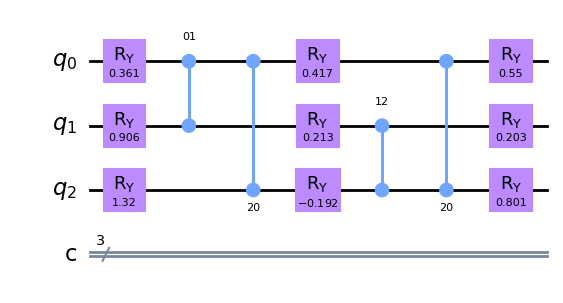

Estimate of |x>:
[ 0.30075226+0.j  0.32959845+0.j  0.5217123 +0.j  0.17833511+0.j
  0.62921306+0.j  0.29373334+0.j -0.03420138+0.j  0.11648051+0.j]


In [36]:
circ = QuantumCircuit(n, n)
circ.compose(build_fixed_ansatz(n, layers, opt_thetas_global),
             inplace=True)
display(circ.draw('mpl'))

backend = Aer.get_backend('aer_simulator')

circ.save_statevector()
t_circ = transpile(circ, backend)
result = backend.run(t_circ).result()

statevec_global = result.get_statevector(circ, decimals=10).data
print(f'Estimate of |x>:\n{statevec_global}')

In [37]:
## |psi> estimate
psi = np.real(np.dot(A_matrix, statevec_global))
psi /= np.linalg.norm(psi)
print(f'Estimate of |Psi>:\n{psi}\n')

## |b>
b_vec = [1 for _ in range(2**n)]
b_vec /= np.sqrt(2**n)
print(f'State |b>:\n{b_vec}\n')

## accuracy
global_accuracy = (np.dot(b_vec,psi))**2
print(f'Accuracy:{global_accuracy}')

Estimate of |Psi>:
[ 0.45492739  0.49856105  0.4340372   0.14836543  0.52347218  0.24437069
 -0.00517341  0.01761921]

State |b>:
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]

Accuracy:0.6705860767336371


Let's plot our cost function with respect to the number of iterations:

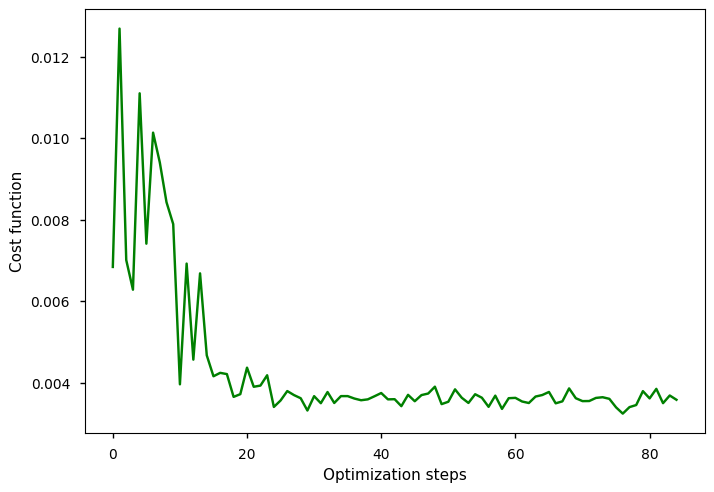

In [38]:
plt.style.use("seaborn-v0_8-notebook")
plt.plot(global_cost_plot, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

### Local cost function

In [45]:
it = 0
local_cost_plot = []

optmized_params_local = minimize(local_cost_function,
                           x0=initial_theta,
                           method='COBYLA', options={'maxiter':200})

Iteration 0 	 Cost evaluation: 0.0021403854951539403
Iteration 1 	 Cost evaluation: 0.004534479094586541
Iteration 2 	 Cost evaluation: 0.0016579710190126606
Iteration 3 	 Cost evaluation: 0.0016770860301913437
Iteration 4 	 Cost evaluation: 0.001748009369118897
Iteration 5 	 Cost evaluation: 0.002159633736646571
Iteration 6 	 Cost evaluation: 0.0020588621339120983
Iteration 7 	 Cost evaluation: 0.001740140623937625
Iteration 8 	 Cost evaluation: 0.0022728180103308016
Iteration 9 	 Cost evaluation: 0.0008505080022441214
Iteration 10 	 Cost evaluation: 0.0001077889997253556
Iteration 11 	 Cost evaluation: 0.0001301438650621045
Iteration 12 	 Cost evaluation: 9.335081018307934e-05
Iteration 13 	 Cost evaluation: 0.00016050104698633882
Iteration 14 	 Cost evaluation: 3.467110722688016e-05
Iteration 15 	 Cost evaluation: 7.835392301713817e-05
Iteration 16 	 Cost evaluation: 0.0003154577090866417
Iteration 17 	 Cost evaluation: 5.38187384384603e-05
Iteration 18 	 Cost evaluation: 0.00052911

In [46]:
optmized_params_local

     fun: -6.5283688427397735e-06
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 88
  status: 1
 success: True
       x: array([-0.05642065,  1.74576102,  0.35455302,  0.774551  ,  0.46596781,
       -0.33549137,  0.83591623,  0.50578942,  2.54264869])

In [47]:
opt_thetas_local = separate_parameters(optmized_params_local.x, layers)
opt_thetas_local

[array([-0.05642065,  1.74576102,  0.35455302]),
 [array([ 0.774551  ,  0.46596781, -0.33549137]),
  array([0.83591623, 0.50578942, 2.54264869])]]

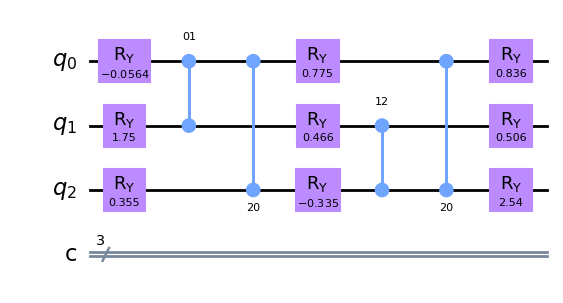

Estimate of |x>:
[0.04207195+0.j 0.04525019+0.j 0.20426678+0.j 0.21720258+0.j
 0.1581148 +0.j 0.12693361+0.j 0.63803603+0.j 0.67755302+0.j]


In [48]:
circ = QuantumCircuit(n, n)
circ.compose(build_fixed_ansatz(n, layers,opt_thetas_local),
             inplace=True)
display(circ.draw('mpl'))

backend = Aer.get_backend('aer_simulator')

circ.save_statevector()
t_circ = transpile(circ, backend)
result = backend.run(t_circ).result()

statevec_local = result.get_statevector(circ, decimals=10).data
print(f'Estimate of |x>:\n{statevec_local}')

In [49]:
## |psi> estimate
psi = np.real(np.dot(A_matrix, statevec_local))
psi /= np.linalg.norm(psi)
print(f'Estimate of |Psi>:\n{psi}\n')

## |b>
b_vec = [1 for _ in range(2**n)]
b_vec /= np.sqrt(2**n)
print(f'State |b>:\n{b_vec}\n')

local_accuracy = (np.dot(b_vec,psi))**2

## accuracy
print(f'Accuracy:{local_accuracy}')

Estimate of |Psi>:
[0.18483812 0.19880133 0.49358205 0.52483958 0.38206224 0.30671728
 0.28031357 0.29767489]

State |b>:
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]

Accuracy:0.8903310643737471


Let's plot our cost function with respect to the number of iterations:

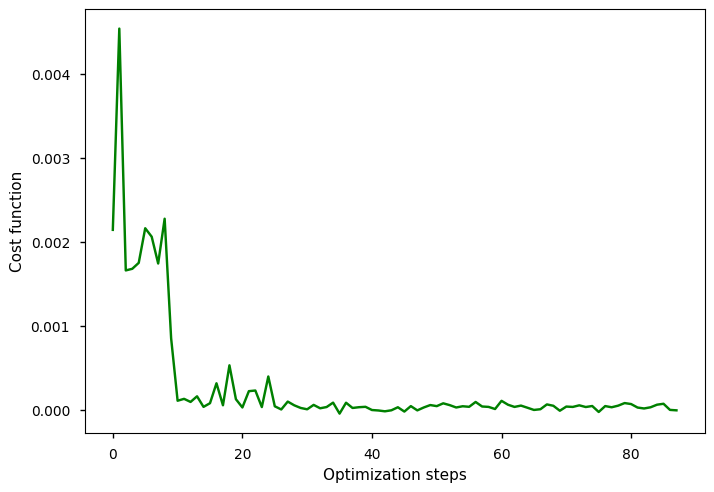

In [50]:
plt.style.use("seaborn-v0_8-notebook")
plt.plot(local_cost_plot, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

In [51]:
print('COBYLA - random\n')

print('global_cost_plot:', global_cost_plot)
print('global_accuracy:', global_accuracy )
print('local_optimized_parameters:', opt_thetas_global)
print('|x> estimate:', statevec_global)
print()

print('local_cost_plot:', local_cost_plot)
print('local_accuracy:', local_accuracy )
print('local_optimized_parameters:', opt_thetas_local)
print('|x> estimate:', statevec_local)
print()

print('random.norm x0:', initial_theta)

COBYLA - random

global_cost_plot: [0.006841227953759188, 0.012695679893644396, 0.007010978787068356, 0.006281997509747228, 0.011106328122665876, 0.007412180388867373, 0.010140117375170843, 0.009410018974195578, 0.008431000356367013, 0.007893292047446154, 0.0039575833749764255, 0.006923474008528774, 0.004563860533026931, 0.0066835066775935426, 0.004670042820895337, 0.004155529552736459, 0.0042392638027386464, 0.004208884529581236, 0.0036491425900888608, 0.003716003647507793, 0.00436711106269172, 0.003897404639045088, 0.00392648868481793, 0.004180261967044019, 0.003401879145823794, 0.003560236452296528, 0.0037919750905202054, 0.003693354543264249, 0.0036156747399289646, 0.003314344398306135, 0.0036669095672448027, 0.0034938781588989, 0.0037682958149961587, 0.0034993317114297984, 0.003667909556984039, 0.0036679794225354945, 0.003608260267281671, 0.0035665980044939927, 0.0035882873754147226, 0.003664304263697904, 0.0037439169500601555, 0.003587999726713642, 0.0035922364051423905, 0.003421

## Acknowledgements
This notebook is based on the algorithm presented in [*Variational Quantum Linear Solver*](https://arxiv.org/abs/1909.05820) by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yigit Subasi, Lukasz Cincio, Patrick J. Coles.

In [52]:
import qiskit.tools.jupyter
%qiskit_version_table